<a href="https://colab.research.google.com/github/Iflgit/GB_CV/blob/main/l4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ShapeMask Instance Segmentation Demo
This Colab demonstrates how to use a ShapeMask model that was trained on Cloud TPU to perform instance segmentation on a sample input image. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. You can also experiment with your own images by editing the input image URL.

### About ShapeMask
An instance segmentation can identify and highlight multiple instances of various objects in an image. For example, in a family photo containing several people, this type of model would automatically highlight each person with a different color. Examples of such instance segmentation models include Mask R-CNN and ShapeMask.

Generally, an instance segmentation model creates detection boxes for various objects in the first step and uses those boxes to identify exact object boundaries and to highlight those objects in the second step. ShapeMask uses a unique technique in the second step - it does not critically depend on the initial detection boxes to identify the exact object boundaries. Instead, the algorithm learns the shapes of various objects by looking at similarities between neighboring pixels. This technique helps ShapeMask produce more accurate results at the end, even for some of the object categories that were not seen during training.  

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the ShapeMask model.

In [ ]:
!git clone -b shapemask https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10497, done.
remote: Counting objects: 100% (699/699), done.
remote: Compressing objects: 100% (442/442), done.
remote: Total 10497 (delta 339), reused 487 (delta 243), pack-reused 9798
Receiving objects: 100% (10497/10497), 45.52 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (7377/7377), done.


## Import libraries

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
import tensorflow.compat.v1 as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/detection')
sys.path.insert(0, 'tpu/models/official/detection/utils')
from utils.object_detection import visualization_utils
from evaluation import coco_utils

## Load the COCO dataset index mapping
This Colab uses a pretrained checkpoint of the ShapeMask model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

--2021-12-19 04:58:00--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png.1’

me_256.png.1        100%[===================>] 116.20K  --.-KB/s    in 0.02s   

2021-12-19 04:58:01 (5.48 MB/s) - ‘me_256.png.1’ saved [118993/118993]

--2021-12-19 04:58:01--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

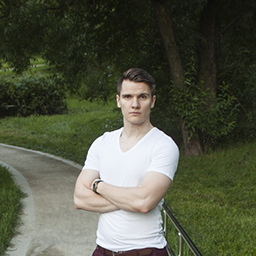

In [ ]:
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
!wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
!wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
image_path = 'me_256.png'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [ ]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket.

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/shapemask/1571767330/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

## Visualize the detection results
Time to check out the result!

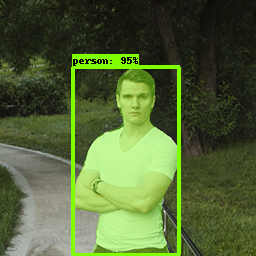

In [ ]:
max_boxes_to_draw = 25   #@param {type:"integer"}
min_score_thresh = 0.20    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_path = 'test_results.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))